## Imports modules

In [ ]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

get data

In [ ]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip downloaded
folder extracted from zip


read data

In [ ]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')[0]
test_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')[0]

max length = 180


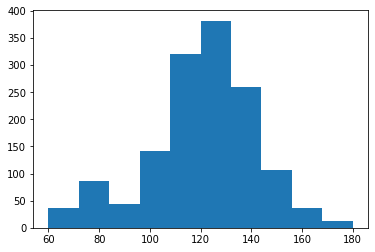

In [ ]:
# Distribution of sample lenghts

lengths = []

for sample in train_data:
  input = sample[0][0]
  input = np.array(list(input))
  len1 = np.where(np.isnan(input))[0][0]
  lengths.append(len1)

max_len = np.max(lengths)
print('max length =',max_len)
_ = plt.hist(lengths)

In [ ]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force


function to return patch

In [ ]:
def interpolate(arr,newSize):
  l = len(arr)
  indices = list(range(0,l))
  newIndices = np.linspace(0, l-1 , newSize)
  newArr = [np.interp(i,indices,arr) for i in newIndices]
  return newArr

In [ ]:
def patch_sample(sample, size, window_size=20, stride=10):

  patches = []
  
  input = sample[0]
  label = sample[1]
  inputLen = len(input[0])
  inputLen = max_len if inputLen > max_len else inputLen
  n_patches = int(np.ceil((inputLen - window_size)/stride) + 1)

  for i in range(n_patches):

    channels = []
    start = stride*i
    end   = stride*i + window_size

    for channel in input:
      values = []
      indicator = []
      for i in range(max_len):
        if np.isnan(channel[i]):
          break
        if (i in range(start,end)):
          values.append(channel[i])
          indicator.append(1)
        else:
          values.append(0)
          indicator.append(0)
      values = interpolate(values, newSize=size)  
      channels.append(values)

    indicator = interpolate(indicator, newSize=size)
    channels.append(indicator)
    patches.append((channels,label))

  return patches

In [ ]:
def patch_dataset(data):
  data1 = []
  for sample in tqdm(data):
    patches = patch_sample(sample, size=90)
    data1.append(patches)
  data1 = [patch for patches in data1 for patch in patches]
  return data1

In [ ]:
train_patchData = patch_dataset(train_data)
test_patchData = patch_dataset(test_data)

In [ ]:
train_patchInputs, train_patchLabels = list(zip(*train_patchData))
test_patchInputs, test_patchLabels = list(zip(*test_patchData))

# convert to np array
train_patchInputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_patchInputs])
test_patchInputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_patchInputs])

# subtract 1 from labels to start indexing from 0
train_patchLabels = np.array(train_patchLabels, dtype=int) - 1
test_patchLabels = np.array(test_patchLabels, dtype=int) - 1

create dataset and dataloader

In [ ]:
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label

In [ ]:
train_patchInputs, val_patchInputs, train_patchLabels, val_patchLabels, = train_test_split(train_patchInputs, train_patchLabels, test_size=0.25, random_state=0)

train_patchDataset = mydataset(train_patchInputs, train_patchLabels)
train_patchLoader = DataLoader(train_patchDataset, batch_size=50, shuffle=True)

val_patchDataset = mydataset(val_patchInputs, val_patchLabels)
val_patchLoader = DataLoader(val_patchDataset, batch_size=50, shuffle=False)

test_patchDataset = mydataset(test_patchInputs, test_patchLabels)
test_patchLoader = DataLoader(test_patchDataset, batch_size=50, shuffle=False)

## define the network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(336, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def evaluate(data_loader):
  y_true= []
  y_pred = []
  net.eval()

  for _, (inputBatch,labelBatch) in enumerate(data_loader):
    with torch.no_grad():
      inputBatch = inputBatch.float()
      labelBatch = labelBatch.type(torch.LongTensor)
      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
      outputBatch = net(inputBatch)
      
      for output,label in zip(outputBatch,labelBatch):
        output, label = output.cpu(), label.cpu()
        y_true.append(label)
        pred = np.argmax(output)
        y_pred.append(pred)

  print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 20, train loss: 2.247, val loss: 2.234
epoch: 40, train loss: 1.557, val loss: 1.604
epoch: 60, train loss: 1.363, val loss: 1.454
epoch: 80, train loss: 1.268, val loss: 1.391
epoch: 100, train loss: 1.209, val loss: 1.392

Finished Training


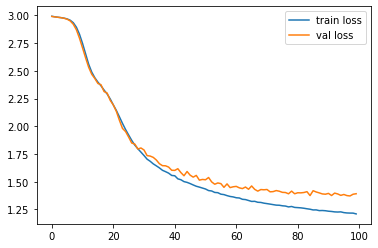

In [ ]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_patchLoader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_patchLoader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 20 == 19:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

In [ ]:
print("evaluation results on train data")
evaluate(train_patchLoader)
print("evaluation results on test data")
evaluate(test_patchLoader)

evaluation results on train data
              precision    recall  f1-score   support

           a     0.7114    0.6820    0.6964      1066
           b     0.6200    0.7102    0.6620       866
           c     0.9506    0.4510    0.6117       938
           d     0.7424    0.6855    0.7128       992
           e     0.9074    0.5658    0.6970      1177
           g     0.7221    0.6093    0.6609       883
           h     0.5676    0.5038    0.5338       792
           l     0.2021    0.9512    0.3334      1127
           m     0.8774    0.6930    0.7744       785
           n     0.7448    0.3896    0.5116       824
           o     0.9615    0.5899    0.7312       890
           p     0.8462    0.5295    0.6514       831
           q     0.7897    0.7887    0.7892       781
           r     0.7005    0.5326    0.6051       751
           s     0.8643    0.6962    0.7712       869
           u     0.8031    0.3210    0.4587       813
           v     0.8379    0.6250    0.7159     